<a href="https://colab.research.google.com/github/natrask/ENM5320/blob/main/Code/TransformerDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch-optimizer
import numpy as np
import torch
import torch.nn as nn
import torch_optimizer as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Generate the base models for the cross attention decoder block along with an architecture that stacks them together.

In [5]:
class CrossAttnDecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, dropout_rate, activation, use_norms):
        super().__init__()

        self.d_model = d_model
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate
        self.activation = activation
        self.use_norms = use_norms

        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=num_heads,
            dropout=dropout_rate,
            batch_first=True,
        )

        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model * 2),
            activation,
            nn.Dropout(dropout_rate),
            nn.Linear(d_model * 2, d_model),
        )

        self.dropout = nn.Dropout(dropout_rate)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def update_dropout_rate(self, new_rate):
        self.dropout_rate = new_rate

        self.multihead_attn.dropout = new_rate

        for module in self.ffn:
            if isinstance(module, nn.Dropout):
                module.p = new_rate

        self.dropout.p = new_rate

    def forward(self, x, z_embedding):
        # input shapes:
        # x: [batch_size (optional), seq_len (number of x eval points), d_model]
        # z_embedding: [batch_size (optional), d_model]
        # in order to make z_embedding work as a "global" token, we need to add a dummy seq_len dimension of 1
        z_embedding = z_embedding.unsqueeze(-2)  # [batch_size (optional), 1, d_model]
        residual = x
        if self.use_norms:
            x_norm = self.norm1(x)
        else:
            x_norm = x

        attn_output, _ = self.multihead_attn(
            query=x_norm,
            key=z_embedding,
            value=z_embedding,
            need_weights=False,
        )

        x = residual + self.dropout(attn_output)

        residual = x
        if self.use_norms:
            x_norm = self.norm2(x)
        else:
            x_norm = x
        x = residual + self.dropout(self.ffn(x_norm))

        return x


class CrossAttnTransformer(nn.Module):
    def __init__(
        self,
        problem_dim,
        output_dim,
        z_dim,
        num_blocks=3,
        latent_dim=128,
        num_heads=4,
        dropout_rate=0.1,
        activation=nn.GELU(),
        use_norms=True,
    ):
        super().__init__()

        self.problem_dim = problem_dim
        self.output_dim = output_dim
        self.z_dim = z_dim
        self.num_blocks = num_blocks
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate
        self.activation = activation
        self.use_norms = use_norms

        self.x_embedding = nn.Linear(self.problem_dim, self.latent_dim)
        self.z_embedding = nn.Linear(self.z_dim, self.latent_dim)

        self.transformer_blocks = nn.ModuleList(
            [
                CrossAttnDecoderLayer(
                    d_model=self.latent_dim,
                    num_heads=num_heads,
                    dropout_rate=dropout_rate,
                    activation=activation,
                    use_norms=use_norms,
                )
                for _ in range(num_blocks)
            ]
        )

        self.final_projection = nn.Linear(self.latent_dim, self.output_dim)

    def forward(self, x, z):
        x_emb = self.x_embedding(x)
        z_emb = self.z_embedding(z)

        for block in self.transformer_blocks:
            x_emb = block(x_emb, z_emb)

        return self.final_projection(x_emb)

In [6]:
model = CrossAttnTransformer(
    problem_dim=1,
    output_dim=1,
    z_dim=1,
    num_blocks=3,
    latent_dim=128,
    num_heads=4,
    dropout_rate=0,
    activation=nn.GELU(),
    use_norms=True,
).to(device)

In [7]:
# z is going to be the angular frequency from 1 to 5, say
z = torch.linspace(1, 5, 12).unsqueeze(-1)

# x are the evaluation points
x = torch.linspace(-torch.pi, torch.pi, 256)

# y are the target functions, sin(z * x), evaluated at the x points
y = torch.stack([torch.sin(z[i] * x) for i in range(z.shape[0])]).unsqueeze(-1)

# we also build a validation set in between the z values:
z_val = (z[1:] + z[:-1]) / 2.0
y_val = torch.stack([torch.sin(z_val[i] * x) for i in range(z_val.shape[0])]).unsqueeze(
    -1
)

In [8]:
z_val.shape, y_val.shape
y, z = y.to(device), z.to(device)
train_dataset = torch.utils.data.TensorDataset(z, y)
train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True)

z_val, y_val = z_val.to(device), y_val.to(device)
val_dataset = torch.utils.data.TensorDataset(z_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=len(z_val), shuffle=False)

x = x.to(device)

In [9]:
optimizer = optim.Shampoo(
    [
        {
            "params": model.parameters(),
            "lr": 0.01,
            "weight_decay": 0,
            "momentum": 0,
            "update_freq": 1,
        }
    ]
)
# optimizer = torch.optim.Adam(
#     [
#         {
#             "params": model.parameters(),
#             "lr": 1e-5,
#             "weight_decay": 0,
#             "momentum": 0,
#         }
#     ]
# )

In [10]:
def save(train_loss_history, val_loss_history):
    with open("cross_attn_transformer_test.pkl", "wb") as f:
        pickle.dump(
            {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "train_loss_history": train_loss_history,
                "val_loss_history": val_loss_history,
            },
            f,
        )


def read():
    with open("cross_attn_transformer_test.pkl", "rb") as f:
        data = pickle.load(f)
        model.load_state_dict(data["model"])
        optimizer.load_state_dict(data["optimizer"])
        train_loss_history = data["train_loss_history"]
        val_loss_history = data["val_loss_history"]
    return train_loss_history, val_loss_history

In [11]:
# read in checkpoint if it exists
try:
    with open("cross_attn_transformer_test.pkl", "rb") as f:
        data = pickle.load(f)
        model.load_state_dict(data["model"])
        optimizer.load_state_dict(data["optimizer"])
        train_loss_history = data["train_loss_history"]
        val_loss_history = data["val_loss_history"]
except FileNotFoundError:
    train_loss_history = []
    val_loss_history = []
    print("No checkpoint found, starting from scratch.")

No checkpoint found, starting from scratch.


In [12]:
time_in_optimizer = 0.0

overall_time_start = time.time()
for epoch in range(0, 1000):
    model.train()
    batch_loss = 0.0
    for i, (z, y) in enumerate(train_loader):
        optimizer.zero_grad()

        # Forward pass
        x_expanded = x.unsqueeze(0).unsqueeze(-1).expand(z.shape[0], -1, -1)

        y_pred = model(x_expanded, z)

        # Compute loss
        loss = nn.functional.mse_loss(y_pred, y)

        batch_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        time_start = time.time()
        optimizer.step()
        time_end = time.time()

        time_in_optimizer += time_end - time_start

    batch_loss /= len(train_loader)
    train_loss_history.append(batch_loss)

    # Validation step
    # model.eval()
    with torch.no_grad():
        batch_loss = 0.0
        for z_val, y_val in val_loader:
            x_expanded = x.unsqueeze(0).unsqueeze(-1).expand(z_val.shape[0], -1, -1)

            y_val_pred = model(x_expanded, z_val)

            batch_loss += nn.functional.mse_loss(y_val_pred, y_val).item()
        batch_loss /= len(val_loader)

    val_loss_history.append(batch_loss)

    print(
        f"Epoch {epoch}: Train Loss: {train_loss_history[-1]:.4e}, Val Loss: {val_loss_history[-1]:.4e}"
    )

    if epoch % 1000 == 0:
        save(train_loss_history, val_loss_history)
        print("Checkpoint saved.")

overall_time_end = time.time()

frac_in_optimizer = time_in_optimizer / (overall_time_end - overall_time_start)
print(f"Fraction of time in optimizer: {frac_in_optimizer:.6f}")

Epoch 0: Train Loss: 3.0052e+00, Val Loss: 1.5967e+00
Checkpoint saved.
Epoch 1: Train Loss: 1.6609e+00, Val Loss: 1.1722e+00
Epoch 2: Train Loss: 1.2185e+00, Val Loss: 9.4276e-01
Epoch 3: Train Loss: 9.8364e-01, Val Loss: 7.3943e-01
Epoch 4: Train Loss: 7.6842e-01, Val Loss: 6.3542e-01
Epoch 5: Train Loss: 6.5809e-01, Val Loss: 5.6473e-01
Epoch 6: Train Loss: 5.8064e-01, Val Loss: 5.0104e-01
Epoch 7: Train Loss: 5.1281e-01, Val Loss: 4.8295e-01
Epoch 8: Train Loss: 4.8990e-01, Val Loss: 5.1071e-01
Epoch 9: Train Loss: 5.1602e-01, Val Loss: 4.6720e-01
Epoch 10: Train Loss: 4.6968e-01, Val Loss: 4.6868e-01
Epoch 11: Train Loss: 4.6896e-01, Val Loss: 4.6196e-01
Epoch 12: Train Loss: 4.6217e-01, Val Loss: 4.8311e-01
Epoch 13: Train Loss: 4.8426e-01, Val Loss: 4.5853e-01
Epoch 14: Train Loss: 4.5784e-01, Val Loss: 4.6722e-01
Epoch 15: Train Loss: 4.6588e-01, Val Loss: 4.5260e-01
Epoch 16: Train Loss: 4.5193e-01, Val Loss: 4.5203e-01
Epoch 17: Train Loss: 4.5219e-01, Val Loss: 4.5197e-01
Ep

[]

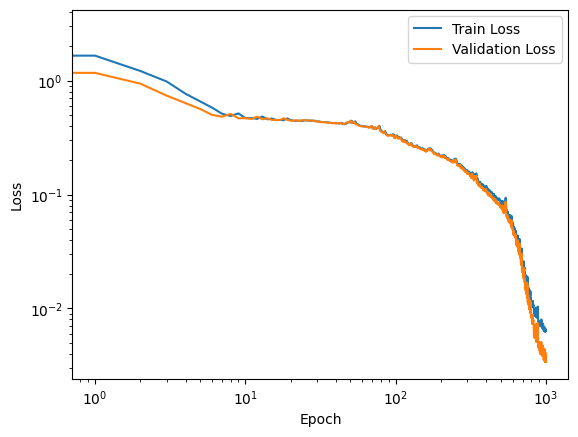

In [13]:
plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.loglog()

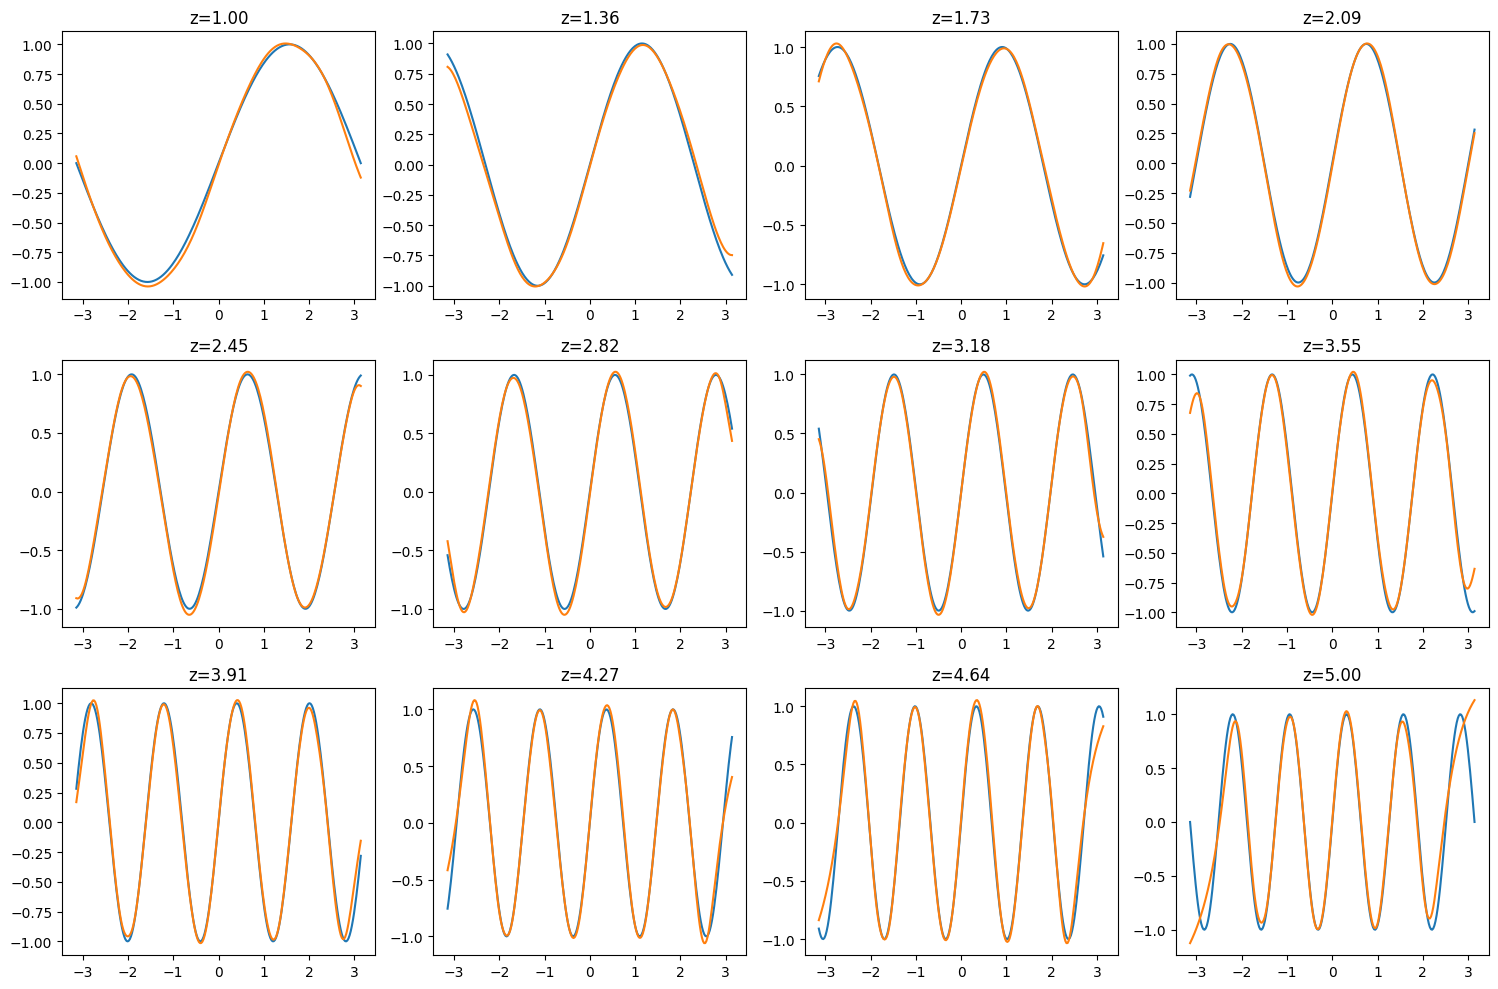

In [14]:
with torch.no_grad():
    z, y = train_dataset.tensors
    x_expanded = x.unsqueeze(0).unsqueeze(-1).expand(z.shape[0], -1, -1)
    y_pred = model(x_expanded, z)

    fig, axs = plt.subplots(3, 4, figsize=(15, 10))
    for i in range(12):
        axs[i // 4, i % 4].plot(x.cpu(), y[i].cpu(), label="True")
        axs[i // 4, i % 4].plot(x.cpu(), y_pred[i].cpu(), label="Predicted")
        axs[i // 4, i % 4].set_title(f"z={z[i].item():.2f}")
    plt.tight_layout()
    plt.show()

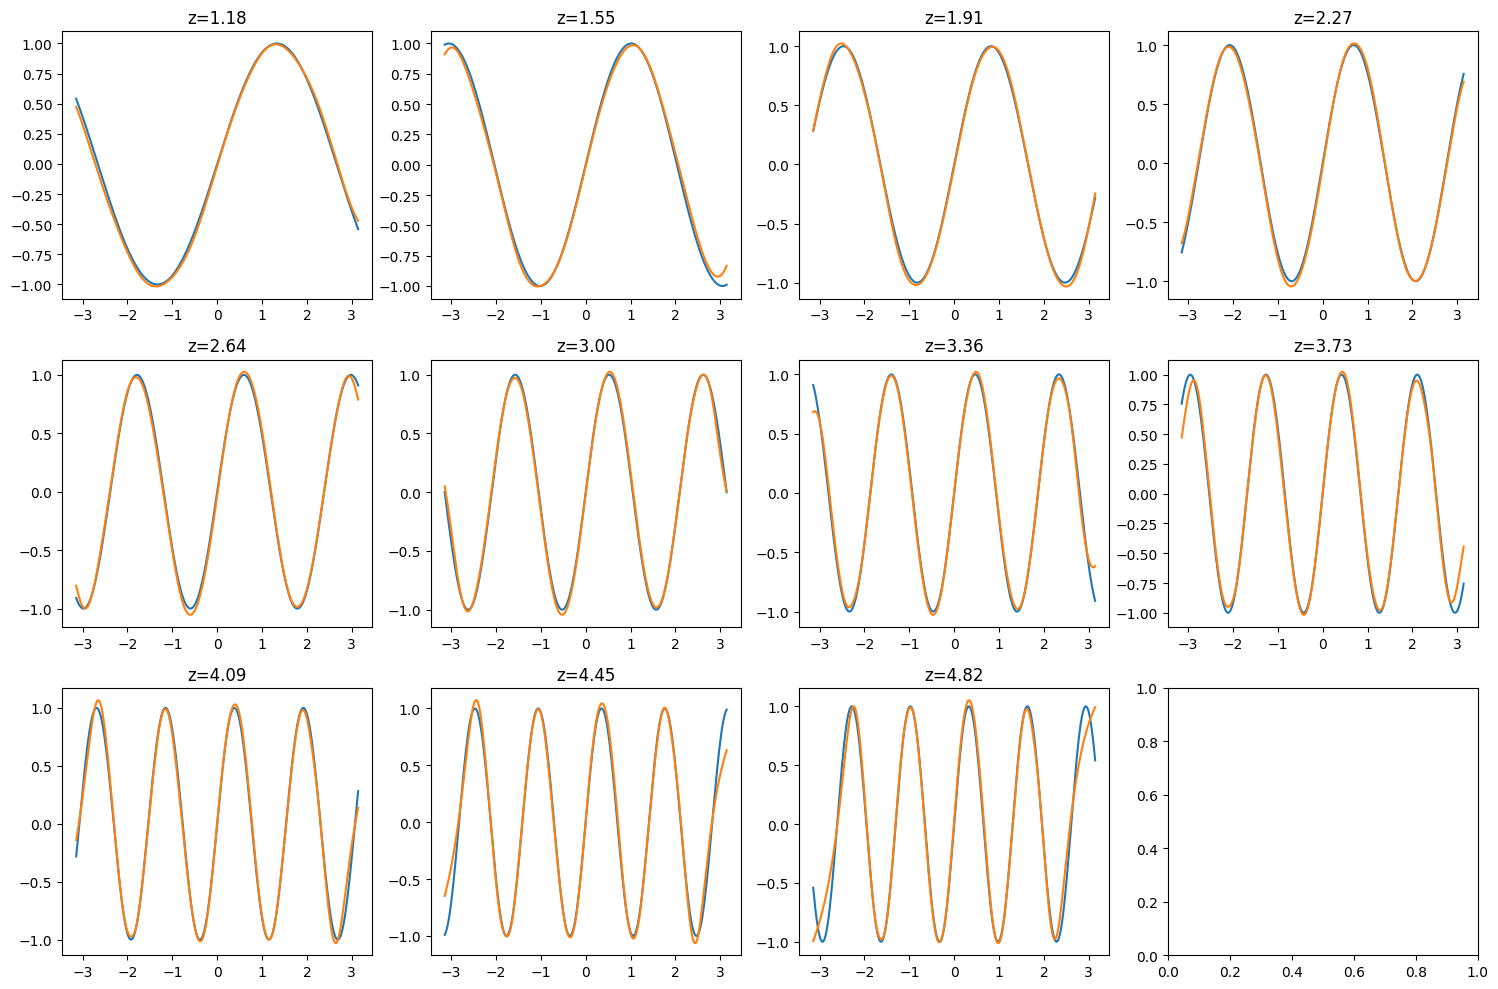

In [15]:
with torch.no_grad():
    for z_val, y_val in val_loader:
        x_expanded = x.unsqueeze(0).unsqueeze(-1).expand(z_val.shape[0], -1, -1)

        y_val_pred = model(x_expanded, z_val)

        fig, axs = plt.subplots(3, 4, figsize=(15, 10))
        for i in range(11):
            axs[i // 4, i % 4].plot(x.cpu(), y_val[i].cpu(), label="True")
            axs[i // 4, i % 4].plot(x.cpu(), y_val_pred[i].cpu(), label="Predicted")
            axs[i // 4, i % 4].set_title(f"z={z_val[i].item():.2f}")
        plt.tight_layout()
        plt.show()